# Chapter 7: Data-Driven Dynamical Systems

Course title:

**MECH 575T: Data-driven modeling and control (Self-directed)**

Reference text:

**Data-Driven Science and Engineering, by Steve Brunton**

## Contents

1. Computing the DMD

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from platform import python_version
python_version()

'3.7.5'

In [3]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## Computing the DMD

In [4]:
# Code from Steve Brunton's book

def dmd_SB(X, Xprime, r):
    # Step 1
    U, Sigma, VT = np.linalg.svd(X, full_matrices=0)
    Ur = U[:, :r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r, :]
    
    # Step 2
    Atilde = np.linalg.solve(Sigmar.T, (Ur.T @ Xprime @ VTr.T).T).T
    
    # Step 3
    Lambda, W = np.linalg.eig(Atilde)
    Lambda = np.diag(Lambda)
    
    # Step 4
    Phi = Xprime @ np.linalg.solve(Sigmar.T, VTr).T @ W
    alpha1 = Sigmar @ VTr[:, 0]
    b = np.linalg.solve(W @ Lambda, alpha1)
    return Phi, Lambda, b


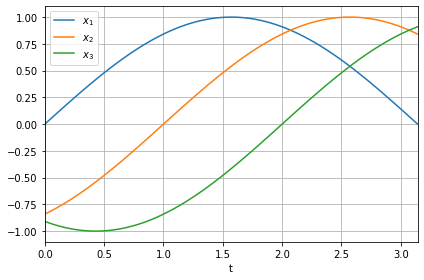

In [5]:
t = np.linspace(0, np.pi, 101)
df = pd.DataFrame(index=pd.Index(t, name='t'))
df['$x_1$'] = np.sin(t)
df['$x_2$'] = np.sin(t - 1)
df['$x_3$'] = np.sin(t - 2)
assert df.shape == (101, 3)
df.plot()
plt.grid()
plt.tight_layout()
plt.savefig('plots/dmd_example1.pdf')
plt.show()

In [6]:
# Prepare x and x_prime data
x = df.iloc[:-1].values.T
x_prime = df.iloc[1:].values.T
assert x.shape == x_prime.shape
x.shape, x_prime.shape

((3, 100), (3, 100))

In [7]:
print(f"x\n{x[:, :5].round(3)}")
print(f"\nx_prime\n{x_prime[:, :5].round(3)}")

x
[[ 0.     0.031  0.063  0.094  0.125]
 [-0.841 -0.824 -0.806 -0.787 -0.767]
 [-0.909 -0.922 -0.934 -0.944 -0.954]]

x_prime
[[ 0.031  0.063  0.094  0.125  0.156]
 [-0.824 -0.806 -0.787 -0.767 -0.747]
 [-0.922 -0.934 -0.944 -0.954 -0.963]]


### Step 1 - Compute the SVD of $\mathbf{X}$

In [8]:
U, Sigma, VT = np.linalg.svd(x,full_matrices=0)
U.shape, Sigma.shape, VT.conj().T.shape

((3, 3), (3,), (100, 3))

In [9]:
Sigma.round(4)

array([8.899 , 8.4147, 0.    ])

In [10]:
# Truncate
r = 2

Ur = U[:,:r]
Sigmar = np.diag(Sigma[:r])
VTr = VT[:r,:]

Ur.shape, Sigmar.shape, VTr.shape

((3, 2), (2, 2), (2, 100))

### Step 2 - Compute $\tilde{\mathbf{A}}$

In [11]:
Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ x_prime @ VTr.T).T).T
Atilde.round(4)

array([[ 0.9995, -0.0332],
       [ 0.0297,  0.9995]])

In [12]:
# Choose a snapshot
i = 10
x[:, i]

array([ 0.30901699, -0.63332387, -0.99338969])

In [13]:
# Reduced state estimate
x_tilde = Atilde.dot(x[:r, i])
x_tilde

array([ 0.32990267, -0.62383316])

In [14]:
Ur.dot(x_tilde)

array([-0.5827499 , -0.26213703,  0.29948342])

### Step 3 - Spectral decomposition of $\tilde{\mathbf{A}}$

In [15]:
Lambda, W = np.linalg.eig(Atilde)
Lambda = np.diag(Lambda)
Lambda.round(4)

array([[0.9995+0.0314j, 0.    +0.j    ],
       [0.    +0.j    , 0.9995-0.0314j]])

### Step 4 - Reconstruct DMD modes

In [16]:
Phi = x_prime @ np.linalg.solve(Sigmar.T,VTr).T @ W
alpha1 = Sigmar @ VTr[:,0]
b = np.linalg.solve(W @ Lambda,alpha1)

In [17]:
Phi.round(4)

array([[-0.2965-0.4954j, -0.2965+0.4954j],
       [-0.5771-0.0181j, -0.5771+0.0181j],
       [-0.327 +0.4758j, -0.327 -0.4758j]])

In [18]:
alpha1.round(4)

array([1.059, 0.643])

In [19]:
b.round(4)

array([0.7431+0.4448j, 0.7431-0.4448j])

In [20]:
# Check results with Steve Brunton's code for DMD
# dmd_SB returns Phi, Lambda, b
result_check = dmd_SB(x, x_prime, r)
assert np.array_equal(Phi, result_check[0])
assert np.array_equal(Lambda, result_check[1])
assert np.array_equal(b, result_check[2])

## My code

In [21]:
def dmd_bt(x, x_prime, r):
    """Compute dynamic matrix decomposition.
    """

    # Step 1
    u, sigma, vh = np.linalg.svd(x, full_matrices=False)
    
    u_r = u[:, :r]
    sigma_r = np.diag(sigma[:r])
    v_r = vh[:r, :]

    # Step 2
    a_tilde = np.linalg.solve(sigma_r.T, (u_r.conj().T.dot(x_prime).dot(v_r.conj().T).T).T)
    # a_tilde2 = u_r.conj().T.dot(x_prime).dot(v_r).dot(np.linalg.inv(sigma_r))
    # assert np.array_equal(a_tilde, a_tilde2)
    
    # Step 3
    lam, w = np.linalg.eig(a_tilde) 

    # Step 4
    phi = x_prime.dot(np.linalg.solve(sigma_r.T, v_r).T).dot(w)
    alpha1 = sigma_r.dot(v_r[:, 0])    
    b = np.linalg.solve(w.dot(np.diag(lam)), alpha1)
    
    return phi, lam, b

In [22]:
phi, lam, b = dmd(x, x_prime, r=2)

NameError: name 'dmd' is not defined

In [ ]:
phi

In [ ]:
lam

In [ ]:
b

In [ ]:
phi, lam, b = dmd_SB(x, x_prime, r=2)

In [ ]:
phi

In [ ]:
lam

In [ ]:
b